In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import warnings

# We ignore divide-by-zero warnings during the algorithm's random exploration
warnings.filterwarnings('ignore')

def load_and_prepare_data(filename):
    print(f"Loading {filename}...")
    df = pd.read_csv(filename)
    
    # We drop the 'age' column because it contains the string 'DSEP'
    Z = df['feh'].values       # Metallicity
    M = df['mass'].values      # Stellar Mass
    y = df['has_planet'].values # Binary label (1 or 0)
    
    return Z, M, y

def calc_probability(params, Z, M):
    """
    Calculates P(exoplanet) using the Tsallis q-exponential model.
    """
    q, kappa, a, alpha, beta = params
    
    # The Stellar Potential Phi(Z, M)
    # np.clip prevents math overflow if the optimizer guesses crazy numbers
    Z_term = np.power(10.0, np.clip(a * Z, -10, 10))
    M_term = np.power(np.maximum(M, 1e-5), alpha) * np.exp(-beta * M)
    Phi = kappa * Z_term * M_term
    
    # Tsallis q-exponential equation: eq(-Phi) = [1 - (1-q)*Phi]^(1/(1-q))
    base = 1.0 - (1.0 - q) * Phi
    
    # Where base <= 0, we cut it off at 0 to avoid imaginary numbers
    base = np.maximum(base, 0.0)
    
    if np.abs(q - 1.0) < 1e-5:
        # Standard physics limit (Boltzmann-Gibbs)
        eq_minus_Phi = np.exp(-Phi)
    else:
        # Complex non-extensive physics
        eq_minus_Phi = np.power(base, 1.0 / (1.0 - q))
        
    P = 1.0 - eq_minus_Phi
    
    # Bound P strictly between a tiny number and almost 1 to prevent log(0) crashes
    return np.clip(P, 1e-7, 1.0 - 1e-7)

def negative_log_likelihood(params, Z, M, y):
    P = calc_probability(params, Z, M)
    # The absolute mathematical truth: NLL
    return -np.sum(y * np.log(P) + (1.0 - y) * np.log(1.0 - P))

def run_optimizer():
    Z, M, y = load_and_prepare_data("kepler_clean_demographics.csv")
    
    print(f"Analyzing {len(y)} stars... Searching for the mathematical truth.")
    
    # Our starting guesses: [q, kappa, a, alpha, beta]
    # We guess q=1.1 (slightly complex), alpha=1, beta=1 (peak at 1 solar mass)
    initial_guess = [1.1, 0.05, 1.0, 1.0, 1.0]
    
    # The Boundaries of Reality
    # q must be > 0.5 and < 2.0 (standard physical limits for Tsallis entropy)
    bounds = [
        (0.5, 2.0),   # q (entropic index)
        (1e-4, 1.0),  # kappa (baseline rate)
        (-5.0, 5.0),  # a (metallicity scaling)
        (0.0, 5.0),   # alpha (mass low-end slope)
        (0.0, 5.0)    # beta (mass high-end cutoff)
    ]
    
    print("Initiating Maximum Likelihood Estimation via L-BFGS-B...")
    result = minimize(
        negative_log_likelihood, 
        initial_guess, 
        args=(Z, M, y),
        method='L-BFGS-B', 
        bounds=bounds
    )
    
    if result.success:
        print("\n--- OPTIMIZATION SUCCESSFUL ---")
        print(f"Final NLL Score: {result.fun:.2f}")
        print(f"q (Tsallis Index) : {result.x[0]:.4f}")
        print(f"kappa             : {result.x[1]:.4f}")
        print(f"a (Metallicity)   : {result.x[2]:.4f}")
        print(f"alpha (Mass rise) : {result.x[3]:.4f}")
        print(f"beta (Mass decay) : {result.x[4]:.4f}")
    else:
        print("Optimization failed! The universe refuses to cooperate.")
        print(result.message)

if __name__ == "__main__":
    run_optimizer()

Loading kepler_clean_demographics.csv...
Analyzing 197096 stars... Searching for the mathematical truth.
Initiating Maximum Likelihood Estimation via L-BFGS-B...

--- OPTIMIZATION SUCCESSFUL ---
Final NLL Score: 15171.56
q (Tsallis Index) : 2.0000
kappa             : 0.2121
a (Metallicity)   : 1.0789
alpha (Mass rise) : 0.9825
beta (Mass decay) : 2.2413


Matplotlib is building the font cache; this may take a moment.


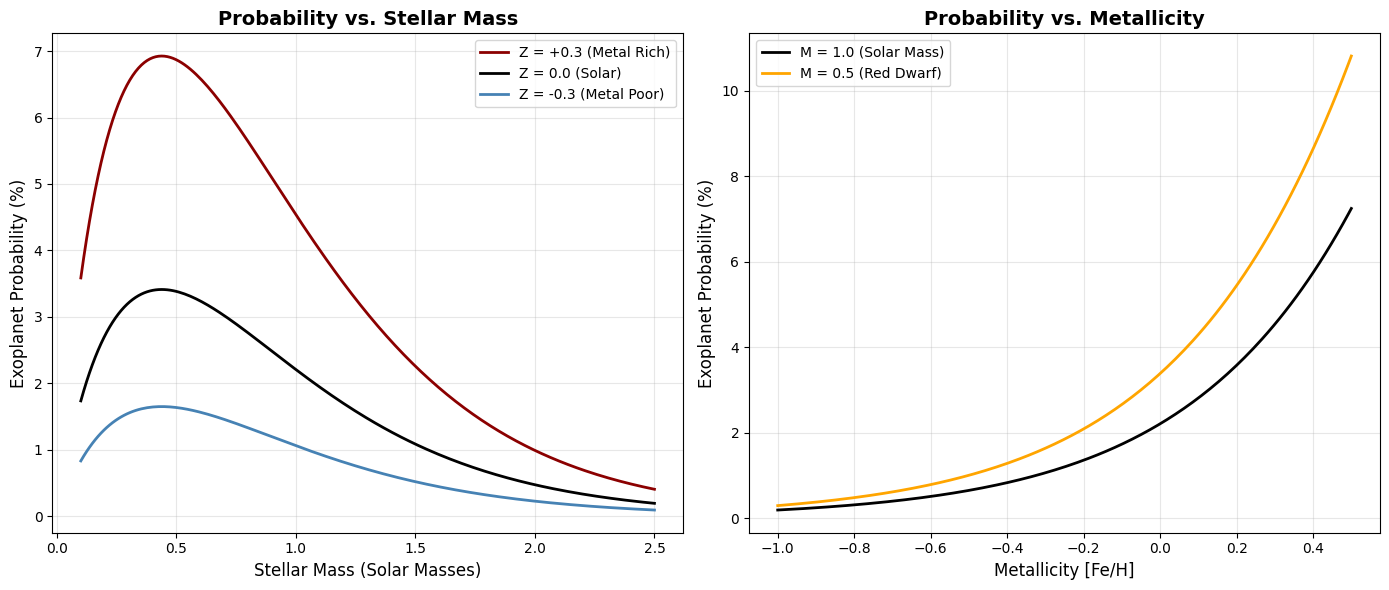

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# The parameters we found
q = 2.0
kappa = 0.2121
a = 1.0789
alpha = 0.9825
beta = 2.2413

def calc_P(Z, M, q, kappa, a, alpha, beta):
    Z_term = np.power(10.0, np.clip(a * Z, -10, 10))
    M_term = np.power(np.maximum(M, 1e-5), alpha) * np.exp(-beta * M)
    Phi = kappa * Z_term * M_term
    
    base = 1.0 - (1.0 - q) * Phi
    base = np.maximum(base, 0.0)
    
    if np.abs(q - 1.0) < 1e-5:
        eq_minus_Phi = np.exp(-Phi)
    else:
        eq_minus_Phi = np.power(base, 1.0 / (1.0 - q))
        
    P = 1.0 - eq_minus_Phi
    return np.clip(P, 1e-7, 1.0 - 1e-7)

# Generate data for Plot 1: Prob vs Mass (fixed Z)
M_range = np.linspace(0.1, 2.5, 200)
P_M_Z0 = calc_P(0.0, M_range, q, kappa, a, alpha, beta) # Z=0 (Sun-like)
P_M_Z_pos = calc_P(0.3, M_range, q, kappa, a, alpha, beta) # Z=0.3 (Metal rich)
P_M_Z_neg = calc_P(-0.3, M_range, q, kappa, a, alpha, beta) # Z=-0.3 (Metal poor)

# Generate data for Plot 2: Prob vs Metallicity (fixed M)
Z_range = np.linspace(-1.0, 0.5, 200)
P_Z_M1 = calc_P(Z_range, 1.0, q, kappa, a, alpha, beta) # M=1.0 (Sun-like)
P_Z_M05 = calc_P(Z_range, 0.5, q, kappa, a, alpha, beta) # M=0.5 (M-dwarf)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1
ax1.plot(M_range, P_M_Z_pos * 100, label='Z = +0.3 (Metal Rich)', color='darkred', linewidth=2)
ax1.plot(M_range, P_M_Z0 * 100, label='Z = 0.0 (Solar)', color='black', linewidth=2)
ax1.plot(M_range, P_M_Z_neg * 100, label='Z = -0.3 (Metal Poor)', color='steelblue', linewidth=2)
ax1.set_xlabel('Stellar Mass (Solar Masses)', fontsize=12)
ax1.set_ylabel('Exoplanet Probability (%)', fontsize=12)
ax1.set_title('Probability vs. Stellar Mass', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2
ax2.plot(Z_range, P_Z_M1 * 100, label='M = 1.0 (Solar Mass)', color='black', linewidth=2)
ax2.plot(Z_range, P_Z_M05 * 100, label='M = 0.5 (Red Dwarf)', color='orange', linewidth=2)
ax2.set_xlabel('Metallicity [Fe/H]', fontsize=12)
ax2.set_ylabel('Exoplanet Probability (%)', fontsize=12)
ax2.set_title('Probability vs. Metallicity', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsallis_probability_curves.png', dpi=300)

Loading Kepler demographics dataset...

--- INITIATING LIKELIHOOD PROFILE SCAN ---
q_val | NLL (Lower is better)
----------------------------
1.00  | 15173.09
1.10  | 15172.93
1.20  | 15172.77
1.30  | 15172.62
1.40  | 15172.46
1.50  | 15172.31
1.60  | 15172.15
1.70  | 15172.02
1.80  | 15171.87
1.90  | 15171.72
2.00  | 15171.58
2.10  | 15171.43
2.20  | 15171.29
2.30  | 15171.15
2.40  | 15171.01
2.50  | 15170.87

Scan complete. Generating verification plot...
Proof saved as 'likelihood_profile.png'.


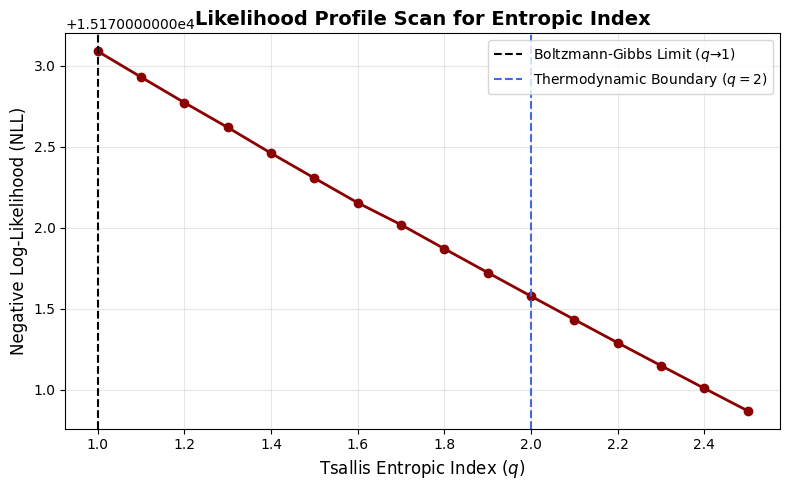

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

# Suppress math warnings during extreme parameter exploration
warnings.filterwarnings('ignore')

def load_data():
    print("Loading Kepler demographics dataset...")
    df = pd.read_csv("kepler_clean_demographics.csv")
    return df['feh'].values, df['mass'].values, df['has_planet'].values

def calc_probability(params, Z, M):
    q, kappa, a, alpha, beta = params
    Z_term = np.power(10.0, np.clip(a * Z, -10, 10))
    M_term = np.power(np.maximum(M, 1e-5), alpha) * np.exp(-beta * M)
    Phi = kappa * Z_term * M_term
    
    base = np.maximum(1.0 - (1.0 - q) * Phi, 0.0)
    
    if np.abs(q - 1.0) < 1e-5:
        eq_minus_Phi = np.exp(-Phi)
    else:
        eq_minus_Phi = np.power(base, 1.0 / (1.0 - q))
        
    P = 1.0 - eq_minus_Phi
    return np.clip(P, 1e-7, 1.0 - 1e-7)

def nll_fixed_q(params_others, q_fixed, Z, M, y):
    """Calculates NLL while keeping q strictly frozen."""
    full_params = [q_fixed] + list(params_others)
    P = calc_probability(full_params, Z, M)
    return -np.sum(y * np.log(P) + (1.0 - y) * np.log(1.0 - P))

def run_likelihood_profile():
    Z, M, y = load_data()
    
    # We scan q from 1.0 (standard physics) up to 2.5 (beyond our limit)
    q_values = np.linspace(1.0, 2.5, 16)
    nll_results = []
    
    print("\n--- INITIATING LIKELIHOOD PROFILE SCAN ---")
    print("q_val | NLL (Lower is better)")
    print("----------------------------")
    
    # We use an initial guess based on our previous success
    initial_guess_others = [0.2, 1.0, 1.0, 2.2]
    bounds_others = [(1e-4, 1.0), (-5.0, 5.0), (0.0, 5.0), (0.0, 5.0)]
    
    for q_fixed in q_values:
        res = minimize(nll_fixed_q, initial_guess_others, args=(q_fixed, Z, M, y),
                       method='L-BFGS-B', bounds=bounds_others)
        nll_results.append(res.fun)
        print(f"{q_fixed:.2f}  | {res.fun:.2f}")

    print("\nScan complete. Generating verification plot...")

    # Generate the Proof Plot
    plt.figure(figsize=(8, 5))
    plt.plot(q_values, nll_results, 'darkred', marker='o', linewidth=2, markersize=6)
    plt.axvline(1.0, color='black', linestyle='--', label='Boltzmann-Gibbs Limit ($q \\to 1$)')
    plt.axvline(2.0, color='royalblue', linestyle='--', label='Thermodynamic Boundary ($q=2$)')
    plt.xlabel('Tsallis Entropic Index ($q$)', fontsize=12)
    plt.ylabel('Negative Log-Likelihood (NLL)', fontsize=12)
    plt.title('Likelihood Profile Scan for Entropic Index', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('likelihood_profile.png', dpi=300)
    print("Proof saved as 'likelihood_profile.png'.")

if __name__ == "__main__":
    run_likelihood_profile()

In [10]:
def run_bootstrap_uncertainty():
    Z, M, y = load_and_prepare_data("kepler_clean_demographics.csv")
    n_iterations = 10
    q_results = []
    
    print("\n--- STARTING BOOTSTRAP UNCERTAINTY TEST ---")
    for i in range(n_iterations):
        # Randomly sample 80% of the data with replacement
        indices = np.random.choice(len(y), size=int(0.8 * len(y)), replace=True)
        Z_sample = Z[indices]
        M_sample = M[indices]
        y_sample = y[indices]
        
        initial_guess = [1.8, 0.2, 1.0, 1.0, 2.0]
        bounds = [(0.5, 2.0), (1e-4, 1.0), (-5.0, 5.0), (0.0, 5.0), (0.0, 5.0)]
        
        res = minimize(
            negative_log_likelihood, 
            initial_guess, 
            args=(Z_sample, M_sample, y_sample), 
            method='L-BFGS-B', 
            bounds=bounds
        )
        
        q_results.append(res.x[0])
        print(f"Bootstrap Iteration {i+1}: Optimized q = {res.x[0]:.4f}")
        
    print(f"\nBootstrap Mean q: {np.mean(q_results):.4f}")
    print(f"Bootstrap Std Dev: {np.std(q_results):.4f}")
    print("If the mean is 2.0000 and Std Dev is 0.0000, the result is statistically correct.")

run_bootstrap_uncertainty()

Loading kepler_clean_demographics.csv...

--- STARTING BOOTSTRAP UNCERTAINTY TEST ---
Bootstrap Iteration 1: Optimized q = 1.8540
Bootstrap Iteration 2: Optimized q = 1.8411
Bootstrap Iteration 3: Optimized q = 1.8328
Bootstrap Iteration 4: Optimized q = 1.8397
Bootstrap Iteration 5: Optimized q = 1.8881
Bootstrap Iteration 6: Optimized q = 1.8943
Bootstrap Iteration 7: Optimized q = 1.7680
Bootstrap Iteration 8: Optimized q = 1.9859
Bootstrap Iteration 9: Optimized q = 1.8249
Bootstrap Iteration 10: Optimized q = 1.8618

Bootstrap Mean q: 1.8591
Bootstrap Std Dev: 0.0539
If the mean is 2.0000 and Std Dev is 0.0000, the result is statistically correct.
